In [156]:
#Necessary imports
from astropy.io import fits #used to open fits files in which data are stored
import pylab #plotting
import glob
mykepler = '2' #add here the source number assigned to you, '1' or '2'
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import LightCurveSimulator
from scipy.signal import medfilt

First, we will have a look at the dataset, we have given you the fits dataset exactly as provided by Kepler, you can download additional datasets [on the Kepler archive](https://archive.stsci.edu/kepler/). We have though made the header anonymous so you cannot see which source you are working with. 

In [47]:
#Fits files are open like this:
lc = fits.open('Data/Object%slc/kplr%s_1.fits'%(mykepler, mykepler))

Fits files are common in astrophysics, they have different extensions, which can be images or tables. The information discribing the data is stored in the header.

In [48]:
#The header for the first extension can be accesses like this:
lc[0].header
#It contains basic information about the object (some of those removed here)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-22'         / file creation date.                            
CREATOR = '911195 FluxExporter2PipelineModule' / pipeline job and program used t
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.24 r60387' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

**You will see some of the header keywords to read 'None of your business', this is because we have anonymized the dataset for you. 

In [49]:
#the data in the extension can be stored like this:
lc[0].data
#the first extension is empty, it just has the information

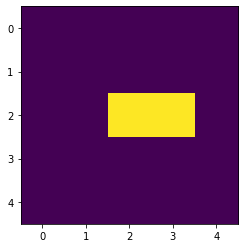

In [50]:
#The last extension holds a small image of the source:
lc[2].header
pylab.imshow(lc[2].data)

In [51]:
#lets have a look at the second extension
lc[1]
#This is a table extension

In [52]:
#Here the beginning has a description of columns in the table, including the units
lc[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                 4375 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

<ErrorbarContainer object of 3 artists>

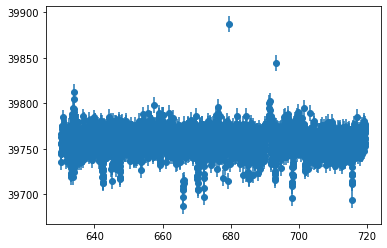

In [54]:
#Measurements errors are also included, you can plot them as follows
pylab.errorbar(lc[1].data['TIME'], lc[1].data['PDCSAP_FLUX'], lc[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='o')
#We'll need to zoom in to see them:

## Your turn: Preparing for fitting:

$\bullet$ locate all transits and make a plot for each

In [55]:
## So far, we have only looked at a subset of the data, the full dataset is stored in the Data folder.
glob.glob('Data/Object%slc/kplr*.fits'%(mykepler)) #Lists all your lightcurve files


['Data/Object2lc/kplr2_11.fits',
 'Data/Object2lc/kplr2_1.fits',
 'Data/Object2lc/kplr2_10.fits',
 'Data/Object2lc/kplr2_17.fits',
 'Data/Object2lc/kplr2_7.fits',
 'Data/Object2lc/kplr2_6.fits',
 'Data/Object2lc/kplr2_16.fits',
 'Data/Object2lc/kplr2_9.fits',
 'Data/Object2lc/kplr2_5.fits',
 'Data/Object2lc/kplr2_15.fits',
 'Data/Object2lc/kplr2_14.fits',
 'Data/Object2lc/kplr2_4.fits',
 'Data/Object2lc/kplr2_8.fits',
 'Data/Object2lc/kplr2_3.fits',
 'Data/Object2lc/kplr2_13.fits',
 'Data/Object2lc/kplr2_12.fits',
 'Data/Object2lc/kplr2_2.fits']

## Plot the full lightcurve

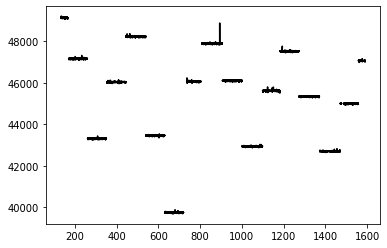

In [66]:
#THis works....
for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    pylab.plot(tmptime, tmpflux, c='k')

# Modelling

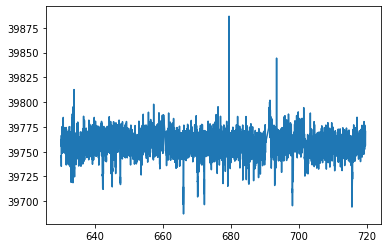

In [106]:
t = lc[1].data['TIME']
f = lc[1].data['PDCSAP_FLUX']

#remove nans
nonan = ~np.isnan(f)
t = t[nonan]
f = f[nonan]

#plot
pylab.plot(t, f)

## Savitzky-Golay

This is a kind of filter that fits polynomials locally to the data. It can be used to smooth data. See the [scipy implimentation](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html).

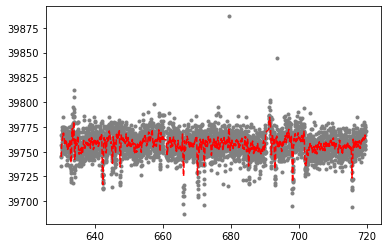

In [127]:
interp_savgol = savgol_filter(f, window_length=41, polyorder=4)
#windowlength is the length of the window over which the polynomial will be fit, polyorder is the order of the polynimial to be fit

pylab.plot(t, f, ls='None', marker='.', c='grey', label='Data')
pylab.plot(t, interp_savgol, ls='--', c='r', label='Savitzky Golay w=11,o=3')
#pylab.xlim(660,670)

(661, 665)

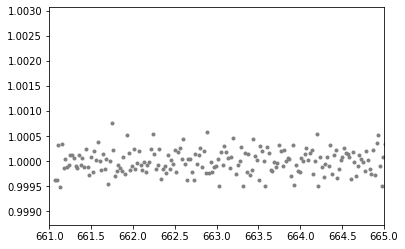

In [189]:
#plot normalised dataset
pylab.plot(t, f/interp_savgol, ls='None', marker='.', c='grey', label='Data')
pylab.xlim(661,665)

## Sssssspline

In [163]:
tnew = numpy.arange(630, 720, 1)
tnew.dtype

dtype('int64')

In [180]:
newfl = interpolate.BSpline(t, f, 1, axis = 0)

(660, 670)

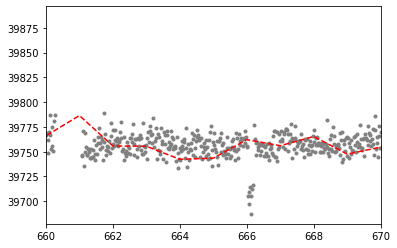

In [183]:
pylab.plot(t, f, ls='None', marker='.', c='grey', label='Data')
pylab.plot(tnew, newfl(tnew), ls='--', c='r', label='Spline')
pylab.xlim(660,670)

(661, 665)

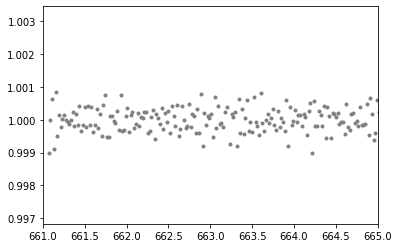

In [190]:
#plot normalised dataset
pylab.plot(t, f/newfl(t), ls='None', marker='.', c='grey', label='Data')
pylab.xlim(661,665)

## median filter 

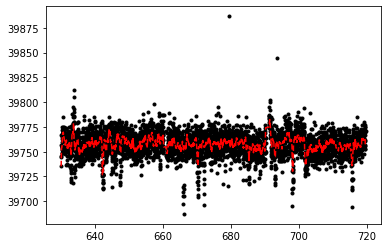

In [191]:
testfil = medfilt(f, kernel_size=21) ##kernel_size is the size of the window over which the median is calculated 
pylab.plot(t, f, c='k', ls='None', marker='.', label='Data')
pylab.plot(t, testfil, ls='--', c='r', label='Median Filter')

(661, 665)

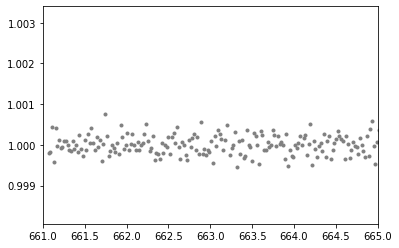

In [192]:
pylab.plot(t, f/testfil, ls='None', marker='.', c='grey', label='Data')
pylab.xlim(661,665)